# Looking at virulence factors in the deepdive

In [11]:
import pathlib, itertools
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt, numpy as np
import scipy.spatial.distance as dist, itertools
import skbio.diversity as div, scipy.stats as stats, skbio.stats.ordination as ordination
from matplotlib.lines import Line2D

sns.set_style('white')
%matplotlib inline

In [12]:
#get patient colors
dd_pat_col = {'0044': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
              '0073': (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
              '001': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
              '004': (1.0, 0.4980392156862745, 0.054901960784313725),
              '005': (1.0, 0.7333333333333333, 0.47058823529411764),
              '006': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
              '007': (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
              '008': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
              '009': (1.0, 0.596078431372549, 0.5882352941176471),
              '010': (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
              '011': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
              '012': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
              '013': (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
              '014': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274)}
dd_pat_col_name = {'patient_' + str(k): v for k, v in dd_pat_col.items()}

#get patient colors on treatment
dd_pat_treat = {'0044': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
              '0073': (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
              '001': sns.color_palette()[0], '004': sns.color_palette()[1],
              '005': sns.color_palette()[1], '006': sns.color_palette()[1],
              '007': sns.color_palette()[0], '008': sns.color_palette()[0],
              '009': sns.color_palette()[1], '010': sns.color_palette()[0],
              '011': sns.color_palette()[0], '012': sns.color_palette()[1],
              '013': sns.color_palette()[1], '014': sns.color_palette()[0]}
dd_pat_treat_name = {'patient_' + str(k): v for k, v in dd_pat_treat.items()}

#get patient dashes on responder
dd_pat_dash = {'0044': (), '0073': (),
               '001': (), '004': (), '005': (),
               '006': (), '007': (3, 2), '008': (3, 2),
               '009': (), '010': (), '011': (),
               '012': (), '013': (), '014': (3, 2)}
dd_pat_dash_name = {'patient_' + str(k): v for k, v in dd_pat_dash.items()}

#colors for sources
dd_source_set = {'shared': (0.878, 0.878, 0.878),
                 'patient': (0.909, 0.470, 0.470),
                 'env': (0.933, 0.674, 0.349),
                 'donor0044': (0.305, 0.749, 0.776),
                 'donor0073': (0.643, 0.450, 0.850),
                 'donor0044_0073': (0.376, 0.470, 0.803),
                 'donor': (0.376, 0.470, 0.803)}

In [3]:
#read in sb results file
vf_seta = pd.read_csv('/Users/ndchu/Documents/uc_fmt/metagenomics/function/vf/all_sbresults_nz_setA.txt.gz',
                     sep='\t', compression='gzip')
vf_setb = pd.read_csv('/Users/ndchu/Documents/uc_fmt/metagenomics/function/vf/all_sbresults_nz_setB.txt.gz',
                     sep='\t', compression='gzip')

In [4]:
#read in metadata
md = pd.read_csv('/Users/ndchu/Documents/uc_fmt/metadata/metadata_stool_dna_NV022018.tsv',
                 sep='\t', dtype={'patient': 'object',
                                  'fmt': 'object',
                                  'fmt_induction': 'object'})
md.loc[:, 'patient_plt'] = 'patient_' + md['patient']

#read in patient metadata
md_pat = pd.read_csv('/Users/ndchu/Documents/uc_fmt/metadata/metadata_patients_2019-04-10.tsv',
                     sep='\t', dtype={'patient': 'object',
                                      'fmt': 'object',
                                      'fmt_induction': 'object'})

In [5]:
#make a dictionary of patient to publication label
pub_label_dict = md_pat.set_index('patient').to_dict()['label_pub']

In [6]:
#filter for where Count > 0
vf_seta_f = vf_seta.loc[vf_seta['Count'] > 0]
vf_setb_f = vf_setb.loc[vf_setb['Count'] > 0]

#get samples that have mgx sequencing
samples = md.loc[(md['reads_mgx'] > 0) & (md['patient'].notnull())]['sample_id'].unique()

#add metadata
vf_seta_f = vf_seta_f.rename(columns={'sample': 'sample_id'}).merge(md)

In [7]:
#read in data on the genes and pathways
gene_map_a = pd.read_csv('/Users/ndchu/Documents/uc_fmt/metagenomics/function/vf/vf_setA_2018DC21_geneids.map.gz',
                         sep='\t', compression='gzip')
gene_map_b = pd.read_csv('/Users/ndchu/Documents/uc_fmt/metagenomics/function/vf/vf_setB_2018DC21_geneids.map.gz',
                       sep='\t', compression='gzip')
#parse labels
gene_map_a.loc[:, 'gene_label'] = gene_map_a['VFDB_setA_pro_faa_label'].str.split('%fig').str[0]
gene_map_a.loc[:, 'taxa'] = gene_map_a['VFDB_setA_pro_faa_label'].str.extract(r'(\[.*\])')[0]

## Look at virulence factor counts over time

In [9]:
# get count of butyrate gene cluster hits
vfa_ct = vf_seta_f[['sample_id', 
                    'Count']].groupby('sample_id').size().rename('sb_clust_count').reset_index()

#add metadata
vfa_ct = vfa_ct.merge(md)

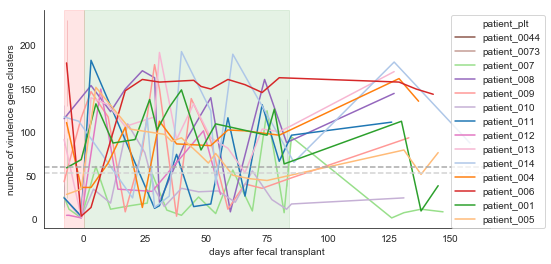

In [13]:
# for each patient, plot the total butyrate cluster counts over time

#get mean abundance for each donor
vfa_mean_0044 = vfa_ct.loc[vfa_ct['patient'] == '0044']['sb_clust_count'].mean()
vfa_mean_0073 = vfa_ct.loc[vfa_ct['patient'] == '0073']['sb_clust_count'].mean()

fig = plt.figure(figsize = (8,4))

ax = sns.lineplot(x='days_past_fmt', y='sb_clust_count',
                  data=vfa_ct,
                  hue='patient_plt', palette=dd_pat_col_name)

#label axes
ax.set_ylabel('number of virulence gene clusters')
ax.set_xlabel('days after fecal transplant')

#label regions of the graph
ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax.axvspan(0, 84, alpha=0.1, color='green') #capsules

#add a line for the mean abundance in the donor samples
ax.axhline(vfa_mean_0044, color='lightgrey', linestyle='dashed')
ax.axhline(vfa_mean_0073, color='darkgrey', linestyle='dashed')

ax.legend(loc='upper left', bbox_to_anchor=(.9, 1))

sns.despine()

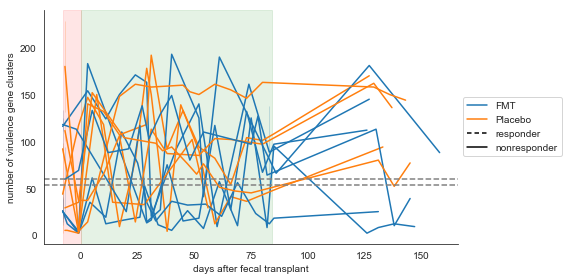

In [15]:
# for each patient, plot the total butyrate cluster counts over time

fig = plt.figure(figsize = (8,4))

ax = sns.lineplot(x='days_past_fmt', y='sb_clust_count',
                  data=vfa_ct,
                  hue='patient_plt', palette=dd_pat_treat_name)

#label axes
ax.set_ylabel('number of virulence gene clusters')
ax.set_xlabel('days after fecal transplant')

#label regions of the graph
ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax.axvspan(0, 84, alpha=0.1, color='green') #capsules

#add a line for the mean abundance in the donor samples
ax.axhline(vfa_mean_0044, color='grey', linestyle='dashed')
ax.axhline(vfa_mean_0073, color='grey', linestyle='dashed')

#make legends for both plots
legend_elements = [Line2D([0], [0], color=sns.color_palette()[0], label='FMT'),
                   Line2D([0], [0], color=sns.color_palette()[1], label='Placebo'),
                   Line2D([0], [0], color='black', dashes=(3, 2), label='responder'),
                   Line2D([0], [0], color='black', dashes=(), label='nonresponder')]
ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1,0.5))

sns.despine()
plt.tight_layout()

#plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/butyrate_genecluster_counts_20190206.png',
#            dpi=300)

## Look at cumulative abundance

In [17]:
# get sum of butyrate gene hits
vfa_sum = vf_seta_f[['sample_id', 
                   'Count',]].groupby('sample_id').sum().reset_index()
vfa_sum.loc[:, 'log_count'] = vfa_sum['Count'].apply(np.log10)

#add any missing samples
sam_missing = [x for x in samples if x not in vfa_sum['sample_id'].values]
missing_df = pd.DataFrame({'sample_id': sam_missing,
                           'Count': [0] * len(sam_missing),
                           'log_count': [0] * len(sam_missing),
                           'Hits': [0] * len(sam_missing)})
vfa_sum = vfa_sum.append(missing_df)

#add metadata
vfa_sum = vfa_sum.merge(md)

/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [25]:
vfa_sum.to_csv('/Users/ndchu/Documents/uc_fmt/metagenomics/function/vf/vf_setA_sum.tsv',
               sep='\t', index=False)

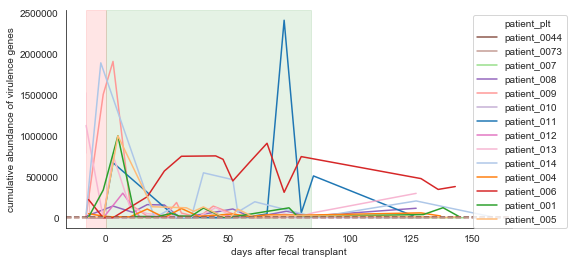

In [45]:
# for each patient, plot the total virulence abundance over time

#get mean abundance for each donor
vfa_mean_0044 = vfa_sum.loc[vfa_sum['patient'] == '0044']['Count'].mean()
vfa_mean_0073 = vfa_sum.loc[vfa_sum['patient'] == '0073']['Count'].mean()

fig = plt.figure(figsize = (8,4))

ax = sns.lineplot(x='days_past_fmt', y='Count',
                  data=vfa_sum,
                  hue='patient_plt', palette=dd_pat_col_name)

#label axes
ax.set_ylabel('cumulative abundance of virulence genes')
ax.set_xlabel('days after fecal transplant')

#label regions of the graph
ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax.axvspan(0, 84, alpha=0.1, color='green') #capsules

#add a line for the mean abundance in the donor samples
ax.axhline(vfa_mean_0044, color=dd_pat_col['0044'], linestyle='dashed')
ax.axhline(vfa_mean_0073, color=dd_pat_col['0073'], linestyle='dashed')

ax.legend(loc='upper left', bbox_to_anchor=(.9, 1))

sns.despine()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/vfa_cumabun_20190207.png',
            dpi=300)

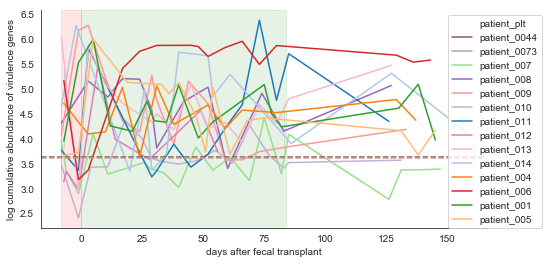

In [32]:
# for each patient, plot the log total virulence abundance over time

#get mean abundance for each donor
vfa_mean_0044 = vfa_sum.loc[vfa_sum['patient'] == '0044']['log_count'].mean()
vfa_mean_0073 = vfa_sum.loc[vfa_sum['patient'] == '0073']['log_count'].mean()

fig = plt.figure(figsize = (8,4))

ax = sns.lineplot(x='days_past_fmt', y='log_count',
                  data=vfa_sum,
                  hue='patient_plt', palette=dd_pat_col_name)

#label axes
ax.set_ylabel('log cumulative abundance of virulence genes')
ax.set_xlabel('days after fecal transplant')

#label regions of the graph
ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax.axvspan(0, 84, alpha=0.1, color='green') #capsules

#add a line for the mean abundance in the donor samples
ax.axhline(vfa_mean_0044, color=dd_pat_col['0044'], linestyle='dashed')
ax.axhline(vfa_mean_0073, color=dd_pat_col['0073'], linestyle='dashed')

ax.legend(loc='upper left', bbox_to_anchor=(.9, 1))

sns.despine()

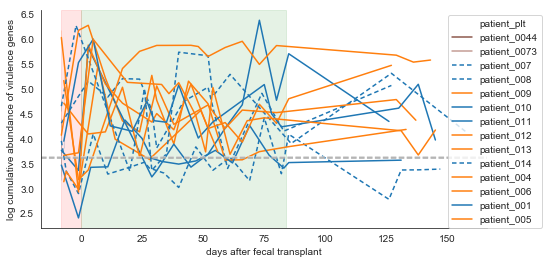

In [33]:
# for each patient, plot the log total virulence abundance over time

#get mean abundance for each donor
vfa_mean_0044 = vfa_sum.loc[vfa_sum['patient'] == '0044']['log_count'].mean()
vfa_mean_0073 = vfa_sum.loc[vfa_sum['patient'] == '0073']['log_count'].mean()

fig = plt.figure(figsize = (8,4))

ax = sns.lineplot(x='days_past_fmt', y='log_count',
                  data=vfa_sum,
                  hue='patient_plt', 
                  palette=dd_pat_treat_name,
                  style='patient_plt',
                  dashes=dd_pat_dash_name)

#label axes
ax.set_ylabel('log cumulative abundance of virulence genes')
ax.set_xlabel('days after fecal transplant')

#label regions of the graph
ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax.axvspan(0, 84, alpha=0.1, color='green') #capsules

#add a line for the mean abundance in the donor samples
ax.axhline(vfa_mean_0044, color='lightgrey', linestyle='dashed')
ax.axhline(vfa_mean_0073, color='darkgrey', linestyle='dashed')

ax.legend(loc='upper left', bbox_to_anchor=(.9, 1))

sns.despine()

## Collapsing over time windows

In [18]:
#let's get simply smash everything into 5-day windows for the cumulative abundance
sum_window_mean_dfs = []
for patient, sub_df in vfa_sum.groupby('patient'):
    #we'll want to join all baseline samples
    #join all abx range samples
    #have the rest in chunks
    if patient in ['0044', '0073']:
        continue
    
    #get baseline and abx
    bl = sub_df.loc[sub_df['days_past_fmt'] < -5]
    bl.loc[:, 'chunk_time'] = -5
    bl_mean = bl.groupby(['patient', 'chunk_time']).mean()[['Count', 'log_count']]
    bl_mean = bl_mean.reset_index()
    abx = sub_df.loc[sub_df['days_past_fmt'].between(-5, 1)]
    if abx.empty:
        abx_mean = pd.DataFrame({'patient': [],
                                 'chunk_time': [],
                                 'Count': [],
                                 'log_count': []})
    else:
        abx.loc[:, 'chunk_time'] = 0
        abx_mean = abx.groupby(['patient', 'chunk_time']).mean()[['Count', 'log_count']]
        abx_mean = abx_mean.reset_index()
    
    pfmt = sub_df.loc[sub_df['days_past_fmt'] > 1]
    pfmt_chunks = []
    for day_range in zip(range(0, int(sub_df['days_past_fmt'].max()), 5),
                         range(5, int(sub_df['days_past_fmt'].max()), 5)):
        chunk = sub_df.loc[sub_df['days_past_fmt'].between(day_range[0], day_range[1])]
        #add time range information
        if chunk.empty:
            chunk = chunk.append({'chunk_time': day_range[1]}, ignore_index=True)
        else:
            chunk.loc[:, 'chunk_time'] = day_range[1]
        pfmt_chunks.append(chunk)
    #now get the mean of values in each chunk
    pfmt_chunks = [chunk.groupby(['patient', 'chunk_time']).mean()[['Count', 'log_count']] \
                   for chunk in pfmt_chunks]
    pfmt_chunks = [chunk.reset_index() for chunk in pfmt_chunks]
    pfmt_mean = pd.concat(pfmt_chunks)
    
    sum_window_mean_dfs.append(pd.concat([bl_mean, abx_mean, pfmt_mean]))

sum_window_mean_df = pd.concat(sum_window_mean_dfs)

/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [21]:
#add metadata
tmp_md = md[['patient', 'patient_donor', 'treatment', 
             'fmt_induction', 'responder_fmt', 
             'patient_plt']].drop_duplicates()
sum_window_mean_df = sum_window_mean_df.merge(tmp_md)

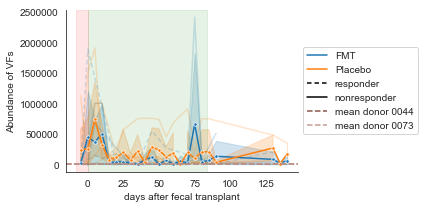

In [29]:
# for each patient, plot the total butyrate cluster counts over time

fig = plt.figure(figsize = (6,3))

#get mean abundance for each donor
vf_mean_0044 = vfa_sum.loc[vfa_sum['patient'] == '0044']['Count'].mean()
vf_mean_0073 = vfa_sum.loc[vfa_sum['patient'] == '0073']['Count'].mean()

ax = sns.lineplot(x='chunk_time', y='Count',
                  data=sum_window_mean_df,
                  hue='patient_plt', 
                  palette=dd_pat_treat_name,
                  style='patient_plt',
                  dashes=dd_pat_dash_name,
                  alpha = 0.2)

ax = sns.lineplot(x='chunk_time', y='Count',
                  data=sum_window_mean_df,
                  hue='treatment', marker='.', markersize=7)

#label axes
ax.set_ylabel('Abundance of VFs')
ax.set_xlabel('days after fecal transplant')

#label regions of the graph
ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax.axvspan(0, 84, alpha=0.1, color='green') #capsules

#add a line for the mean abundance in the donor samples
ax.axhline(vf_mean_0044, color=dd_pat_col['0044'], linestyle='dashed')
ax.axhline(vf_mean_0073, color=dd_pat_col['0073'], linestyle='dashed')

#make legends for both plots
legend_elements = [Line2D([0], [0], color=sns.color_palette()[0], label='FMT'),
                   Line2D([0], [0], color=sns.color_palette()[1], label='Placebo'),
                   Line2D([0], [0], color='black', dashes=(3, 2), label='responder'),
                   Line2D([0], [0], color='black', dashes=(), label='nonresponder'),
                   Line2D([0], [0], color=dd_pat_col['0044'], linestyle='dashed', 
                          label='mean donor 0044'),
                   Line2D([0], [0], color=dd_pat_col['0073'], linestyle='dashed', 
                          label='mean donor 0073')]
ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1,0.5))

sns.despine()
plt.tight_layout()

#plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/cazy_gh_genecluster_counts_mean_20190206.png',
#            dpi=300)

/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


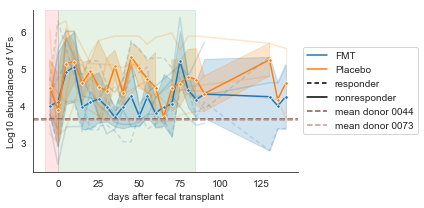

In [22]:
# for each patient, plot the total butyrate cluster counts over time

fig = plt.figure(figsize = (6,3))

#get mean abundance for each donor
vf_mean_0044 = vfa_sum.loc[vfa_sum['patient'] == '0044']['log_count'].mean()
vf_mean_0073 = vfa_sum.loc[vfa_sum['patient'] == '0073']['log_count'].mean()

ax = sns.lineplot(x='chunk_time', y='log_count',
                  data=sum_window_mean_df,
                  hue='patient_plt', 
                  palette=dd_pat_treat_name,
                  style='patient_plt',
                  dashes=dd_pat_dash_name,
                  alpha = 0.2)

ax = sns.lineplot(x='chunk_time', y='log_count',
                  data=sum_window_mean_df,
                  hue='treatment', marker='.', markersize=7)

#label axes
ax.set_ylabel('Log10 abundance of VFs')
ax.set_xlabel('days after fecal transplant')

#label regions of the graph
ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax.axvspan(0, 84, alpha=0.1, color='green') #capsules

#add a line for the mean abundance in the donor samples
ax.axhline(vf_mean_0044, color=dd_pat_col['0044'], linestyle='dashed')
ax.axhline(vf_mean_0073, color=dd_pat_col['0073'], linestyle='dashed')

#make legends for both plots
legend_elements = [Line2D([0], [0], color=sns.color_palette()[0], label='FMT'),
                   Line2D([0], [0], color=sns.color_palette()[1], label='Placebo'),
                   Line2D([0], [0], color='black', dashes=(3, 2), label='responder'),
                   Line2D([0], [0], color='black', dashes=(), label='nonresponder'),
                   Line2D([0], [0], color=dd_pat_col['0044'], linestyle='dashed', 
                          label='mean donor 0044'),
                   Line2D([0], [0], color=dd_pat_col['0073'], linestyle='dashed', 
                          label='mean donor 0073')]
ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1,0.5))

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/vf_cumulative_abun_2019-05-05.pdf',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/vf_cumulative_abun_2019-05-05.png',
            dpi=300)

In [13]:
#let's get simply smash everything into 5-day windows for the VF counts
ct_window_mean_dfs = []
for patient, sub_df in vfa_ct.groupby('patient'):
    #we'll want to join all baseline samples
    #join all abx range samples
    #have the rest in chunks
    if patient in ['0044', '0073']:
        continue
    
    #get baseline and abx
    bl = sub_df.loc[sub_df['days_past_fmt'] < -5]
    bl.loc[:, 'chunk_time'] = -5
    bl_mean = bl.groupby(['patient', 'chunk_time']).mean()[['sb_clust_count']]
    bl_mean = bl_mean.reset_index()
    abx = sub_df.loc[sub_df['days_past_fmt'].between(-5, 1)]
    if abx.empty:
        abx_mean = pd.DataFrame({'patient': [],
                                 'chunk_time': [],
                                 'sb_clust_count': []})
    else:
        abx.loc[:, 'chunk_time'] = 0
        abx_mean = abx.groupby(['patient', 'chunk_time']).mean()[['sb_clust_count']]
        abx_mean = abx_mean.reset_index()
    
    pfmt = sub_df.loc[sub_df['days_past_fmt'] > 1]
    pfmt_chunks = []
    for day_range in zip(range(0, int(sub_df['days_past_fmt'].max()), 5),
                         range(5, int(sub_df['days_past_fmt'].max()), 5)):
        chunk = sub_df.loc[sub_df['days_past_fmt'].between(day_range[0], day_range[1])]
        #add time range information
        if chunk.empty:
            chunk = chunk.append({'chunk_time': day_range[1]}, ignore_index=True)
        else:
            chunk.loc[:, 'chunk_time'] = day_range[1]
        pfmt_chunks.append(chunk)
    #now get the mean of values in each chunk
    pfmt_chunks = [chunk.groupby(['patient', 'chunk_time']).mean()[['sb_clust_count']] \
                   for chunk in pfmt_chunks]
    pfmt_chunks = [chunk.reset_index() for chunk in pfmt_chunks]
    pfmt_mean = pd.concat(pfmt_chunks)
    
    ct_window_mean_dfs.append(pd.concat([bl_mean, abx_mean, pfmt_mean]))

ct_window_mean_df = pd.concat(ct_window_mean_dfs)

/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [14]:
#add metadata
tmp_md = md[['patient', 'patient_donor', 'treatment', 
             'fmt_induction', 'responder_fmt', 
             'patient_plt']].drop_duplicates()
ct_window_mean_df = ct_window_mean_df.merge(tmp_md)

In [15]:
#write this to a file
ct_window_mean_df.to_csv('/Users/ndchu/Documents/uc_fmt/metagenomics/function/vf/window_means_cts_2019-05-09.tsv',
                         sep='\t', index=False)

In [ ]:
#read this to a file
ct_window_mean_df = pd.read_csv('/Users/ndchu/Documents/uc_fmt/metagenomics/function/vf/window_means_cts_2019-05-09.tsv',
                         sep='\t')

In [16]:
#Do T-test for each data point
ttest_res = []
for time, sub_df in ct_window_mean_df.groupby('chunk_time'):
    fmt = sub_df.loc[sub_df['treatment'] == 'fmt']
    placebo = sub_df.loc[sub_df['treatment'] == 'placebo']
    t_res = stats.ttest_ind(fmt['sb_clust_count'], placebo['sb_clust_count'])
    ttest_res.append([time, *t_res])
ttest_res = pd.DataFrame(ttest_res, columns=['chunk_time', 't_stat', 'p'])

/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


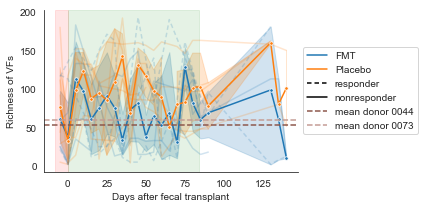

In [26]:
# for each patient, plot the total butyrate cluster counts over time

fig = plt.figure(figsize = (6,3))

#get mean abundance for each donor
vf_mean_0044 = vfa_ct.loc[vfa_ct['patient'] == '0044']['sb_clust_count'].mean()
vf_mean_0073 = vfa_ct.loc[vfa_ct['patient'] == '0073']['sb_clust_count'].mean()

ax = sns.lineplot(x='chunk_time', y='sb_clust_count',
                  data=ct_window_mean_df,
                  hue='patient_plt', 
                  palette=dd_pat_treat_name,
                  style='patient_plt',
                  dashes=dd_pat_dash_name,
                  alpha = 0.2)

ax = sns.lineplot(x='chunk_time', y='sb_clust_count',
                  data=ct_window_mean_df,
                  hue='treatment', marker='.', markersize=7)

#label axes
ax.set_ylabel('Richness of VFs')
ax.set_xlabel('Days after fecal transplant')

#label regions of the graph
ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax.axvspan(0, 84, alpha=0.1, color='green') #capsules

#add a line for the mean abundance in the donor samples
ax.axhline(vf_mean_0044, color=dd_pat_col['0044'], linestyle='dashed')
ax.axhline(vf_mean_0073, color=dd_pat_col['0073'], linestyle='dashed')

#make legends for both plots
legend_elements = [Line2D([0], [0], color=sns.color_palette()[0], label='FMT'),
                   Line2D([0], [0], color=sns.color_palette()[1], label='Placebo'),
                   Line2D([0], [0], color='black', dashes=(3, 2), label='responder'),
                   Line2D([0], [0], color='black', dashes=(), label='nonresponder'),
                   Line2D([0], [0], color=dd_pat_col['0044'], linestyle='dashed', 
                          label='mean donor 0044'),
                   Line2D([0], [0], color=dd_pat_col['0073'], linestyle='dashed', 
                          label='mean donor 0073')]
ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1,0.5))

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/vf_richness_mean_2019-05-05.pdf',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/vf_richness_mean_2019-05-05.png',
            dpi=300)

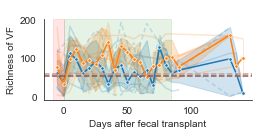

In [18]:
# for each patient, plot the total butyrate cluster counts over time

fig = plt.figure(figsize = (3.75,2))

#get mean abundance for each donor
mean_0044 = vfa_ct.loc[vfa_ct['patient'] == '0044']['sb_clust_count'].mean()
mean_0073 = vfa_ct.loc[vfa_ct['patient'] == '0073']['sb_clust_count'].mean()

ax = sns.lineplot(x='chunk_time', y='sb_clust_count',
                  data=ct_window_mean_df,
                  hue='patient_plt', 
                  palette=dd_pat_treat_name,
                  style='patient_plt',
                  dashes=dd_pat_dash_name,
                  alpha = 0.2)

ax = sns.lineplot(x='chunk_time', y='sb_clust_count',
                  data=ct_window_mean_df,
                  hue='treatment', marker='.', markersize=7)

#label axes
ax.set_ylabel('Richness of VF')
ax.set_xlabel('Days after fecal transplant')

#label regions of the graph
ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax.axvspan(0, 84, alpha=0.1, color='green') #capsules

#add a line for the mean abundance in the donor samples
ax.axhline(mean_0044, color=dd_pat_col['0044'], linestyle='dashed')
ax.axhline(mean_0073, color=dd_pat_col['0073'], linestyle='dashed')

ax.legend_.remove()

#add asterisks for signficant differences
for time in ttest_res.loc[ttest_res['p'] < 0.05]['chunk_time'].values:
    ax.annotate('*', xy=(time, 205), size=15, ha='center')

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/vf_genecluster_counts_mean_nolgd_2019-05-09.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/vf_genecluster_counts_mean_nolgd_2019-05-09.pdf',
            dpi=300)

## Does VF gennerally only reflect E coli?

In [54]:
def relative_abundance_tidy(df, sample_col, value_col,
                            rel_abun_name='rel_abun'):
    """
    Take a tidy table, where the samples are in sample_col and the values
    to be converted to relative abundance are in value_col.
    
    sample_col can also be a list of columns
    """
    #define relative abundance calculation
    rel_abun = lambda x: (x / x.sum())
    #calculate new values
    values = df.groupby(sample_col)[value_col].transform(rel_abun)
    values = values.rename(rel_abun_name)
    #add to df and return
    df = pd.concat([df, values], axis=1)
    return df

In [55]:
#read in 16S data
otu = pd.read_csv('/Users/ndchu/Documents/uc_fmt/16S/dada2_AG302018/dd_asv_tab_f.tsv',
                  sep='\t', index_col=0).astype(int)
otu_rare = pd.read_csv('/Users/ndchu/Documents/uc_fmt/16S/dada2_AG302018/dd_asv_tab_f_rare8500.tsv',
                       sep='\t', index_col=0).astype(int)

otu_tidy = pd.melt(otu.reset_index(), id_vars='#OTU ID', 
                   var_name='sample_id', value_name='count')
otu_tidy = otu_tidy.merge(pd.melt(otu_rare.reset_index(), id_vars='#OTU ID', 
                          var_name='sample_id', value_name='count_rare'))
otu_tidy = relative_abundance_tidy(otu_tidy, 'sample_id', 'count')

#read in taxa
taxa = pd.read_csv('/Users/ndchu/Documents/uc_fmt/16S/dada2_AG302018/taxonomy.tsv',
                   sep='\t')
taxa[['domain', 'phylum', 'class',
      'order', 'family', 'genus',
      'species']] = taxa['Taxon'].str.split(';', expand=True)

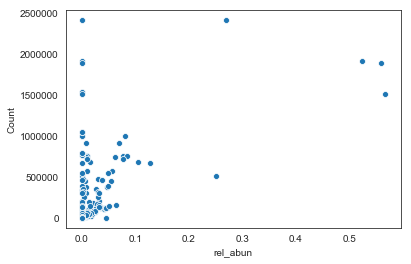

In [60]:
#otu
otu_tidy_taxa = otu_tidy.merge(taxa, left_on='#OTU ID', right_on='Feature ID')
ecoli_tidy = otu_tidy_taxa.loc[otu_tidy_taxa['genus'] == 'D_5__Escherichia-Shigella'
                              ]
plot_df = vfa_sum.merge(ecoli_tidy)

#plot these against each other
ax = sns.scatterplot(x='rel_abun', y='Count', data=plot_df)

## Engraftment of virulence factors

In [15]:
donor_vf_dict = {'0044': set(vf_seta_f.loc[vf_seta_f['patient'] == '0044']['Family']),
                 '0073': set(vf_seta_f.loc[vf_seta_f['patient'] == '0073']['Family'])}

In [51]:
vf_eng = []
for patient, sub_df in vf_seta_f.groupby('patient'):
    if patient in ['0044', '0073']:
        continue
    #get patient baseline vf genes
    bl_sam = md.loc[(md['patient'] == patient) & \
                    (md['days_past_fmt'] < -5)]['sample_id'].tolist()
    bl_vf = set(sub_df.loc[sub_df['sample_id'].isin(bl_sam)]['Family'])
    
    #get patient pfmt amr genes that occur at least 3 times
    pfmt_sam = md.loc[(md['patient'] == patient) & \
                      (md['days_past_fmt'] > 0)]['sample_id'].tolist()
    tmp = sub_df.loc[sub_df['sample_id'].isin(pfmt_sam)]
    tmp = tmp.groupby('Family').size()
    pfmt_vf = set(tmp.loc[tmp >= 3].index)
    
    if sub_df['treatment'].iloc[0] == 'placebo':
        eng_vf = pfmt_vf - bl_vf
        #add env vf
        vf_eng.extend([[patient, x, 'env'] for x in eng_vf])
        #add patient vf
        pat_vf = pfmt_vf & bl_vf
        vf_eng.extend([[patient, x, 'patient'] for x in pat_vf])
    else:
        donor = sub_df['fmt_induction'].iloc[0]
        donor_vf = donor_vf_dict[donor]
        #get engrafted donor vf
        eng_vf = (donor_vf & pfmt_vf) - bl_vf
        vf_eng.extend([[patient, x, 'donor'] for x in eng_vf])
        #get shared vf
        shared_vf = donor_vf & pfmt_vf & bl_vf
        vf_eng.extend([[patient, x, 'shared'] for x in shared_vf])
        #get all the unknowns
        env_vf = pfmt_vf - donor_vf - bl_vf
        vf_eng.extend([[patient, x, 'env'] for x in env_vf])
        #get patient amr
        pat_vf = (pfmt_vf - donor_vf) & bl_vf
        vf_eng.extend([[patient, x, 'patient'] for x in pat_vf])

vf_eng_df = pd.DataFrame(vf_eng, columns=['patient', 'vf_family', 'source'])

In [53]:
# Get summary numbers for each patient
vf_eng_cts_pp = vf_eng_df.groupby(['patient', 'source']).size()
vf_eng_freq = vf_eng_cts_pp / vf_eng_df.groupby('patient').size()
vf_eng_freq = vf_eng_freq.rename('vf_freq').reset_index()

In [57]:
# get list of fmt patients
fmt_pats = set(md.loc[md['treatment'] == 'fmt']['patient'].unique())

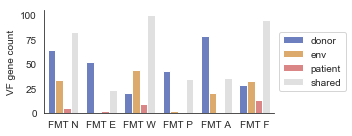

In [62]:
# raw numbers of virulence factors and their sources
vf_eng_cts_pp = vf_eng_cts_pp.rename('vf_ct')
tmp = vf_eng_cts_pp.reset_index()

plt_df = tmp.loc[tmp['patient'].isin(fmt_pats)]
plt_df.loc[:, 'patient_plt'] = plt_df['patient'].apply(lambda x: pub_label_dict[x])

fig = plt.figure(figsize = (5,2))

ax = sns.barplot(x='patient_plt', y='vf_ct',
                 hue='source', data=plt_df,
                 palette=dd_source_set)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_ylabel('VF gene count')
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

## Longitudinal engraftment

In [19]:
#colors for sources
dd_source_set = {'shared': (0.878, 0.878, 0.878),
                 'patient': (0.909, 0.470, 0.470),
                 'env': (0.933, 0.674, 0.349),
                 'donor0044': (0.305, 0.749, 0.776),
                 'donor0073': (0.643, 0.450, 0.850),
                 'donor0044_0073': (0.376, 0.470, 0.803),
                 'donor': (0.376, 0.470, 0.803)}

#make a dictionary of patient to publication label
pub_label_dict = md_pat.set_index('patient').to_dict()['label_pub']

In [23]:
vf_source = []
for patient, sub_df in vf_seta_f.groupby('patient'):
    if patient in ['0044', '0073']:
        continue
    #get patient baseline vf genes
    bl_sam = md.loc[(md['patient'] == patient) & \
                    (md['days_past_fmt'] < -5)]['sample_id'].tolist()
    bl_vf = set(sub_df.loc[sub_df['sample_id'].isin(bl_sam)]['Family'])
    
    for sample, sub_sub_df in sub_df.groupby('sample_id'):
        sam_vf = set(sub_sub_df['Family'])
        
        if sub_df['treatment'].iloc[0] == 'placebo':
            pat_vf = sam_vf & bl_vf #patient vf
            env_vf = sam_vf - bl_vf #env vf
            
            vf_source.extend([[patient, sample, 
                                x, 'patient'] for x in pat_vf])
            vf_source.extend([[patient, sample, 
                                x, 'env'] for x in env_vf])
        
        elif sub_df['treatment'].iloc[0] == 'fmt':
            donor = sub_df['fmt_induction'].iloc[0]
            donor_vf = donor_vf_dict[donor]
            
            pat_vf = (sam_vf & bl_vf) - donor_vf #patient amr
            don_vf = (donor_vf & sam_vf) - bl_vf #donor amr
            shr_vf = donor_vf & sam_vf & bl_vf #shared amr
            env_vf = sam_vf - donor_vf - bl_vf #env amr
            
            vf_source.extend([[patient, sample, 
                                x, 'patient'] for x in pat_vf])
            vf_source.extend([[patient, sample, 
                                x, 'env'] for x in env_vf])
            vf_source.extend([[patient, sample, 
                                x, 'donor'] for x in don_vf])
            vf_source.extend([[patient, sample, 
                                x, 'shared'] for x in shr_vf])

vf_source_df = pd.DataFrame(vf_source, 
                             columns=['patient', 'sample_id', 
                                      'Family', 'source'])

In [24]:
# add metadata
vf_source_df = vf_source_df.merge(vf_seta_f)

In [18]:
# write to a file
vf_source_df.to_csv('/Users/ndchu/Documents/uc_fmt/metagenomics/function/vf/vf_source_2019-04-16.tsv.gz',
                     sep='\t', index=False, compression='gzip')

In [20]:
# read in a file
vf_source_df = pd.read_csv('/Users/ndchu/Documents/uc_fmt/metagenomics/function/vf/vf_source_2019-04-16.tsv.gz',
                           sep='\t', compression='gzip', dtype={'patient': 'object'})

In [21]:
# get frequencies over time
vf_source_freq = vf_source_df.groupby(['patient', 'sample_id', 
                                         'days_past_fmt', 'source']).size()
vf_sample_sum = vf_source_df.groupby(['patient', 'sample_id', 
                                         'days_past_fmt']).size()

vf_source_freq = vf_source_freq.rename('source_count').reset_index()
vf_sample_sum = vf_sample_sum.rename('vf_count').reset_index()

vf_source_freq = vf_source_freq.merge(vf_sample_sum)
vf_source_freq.loc[:, 'source_freq'] = vf_source_freq['source_count'] / vf_source_freq['vf_count']

In [25]:
#get rid of samples with less than 2 butyrate genes, since they are likely errors
vf_source_freq = vf_source_freq.loc[vf_source_freq['vf_count'] > 1]

#fill the zeroes
vf_source_freq_ftab = vf_source_freq.pivot(index='sample_id',
                                               columns='source',
                                               values='source_freq')
vf_source_freq_filled = pd.melt(vf_source_freq_ftab.reset_index(),
                                  id_vars='sample_id',
                                  var_name='source',
                                  value_name='source_freq')
#add metadata
vf_source_freq_filled = vf_source_freq_filled.fillna(0)
tmp = vf_source_freq[['sample_id', 'source', 'source_count']]
vf_source_freq_filled = vf_source_freq_filled.merge(tmp, how='outer').fillna(0)
tmp = vf_source_freq[['sample_id', 'vf_count']].drop_duplicates()
vf_source_freq_filled = vf_source_freq_filled.merge(tmp)
vf_source_freq_filled = vf_source_freq_filled.merge(md)

/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


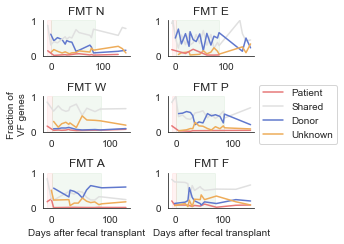

In [10]:
# plot these vf sources
#collapse all donor categories

fig = plt.figure(figsize = (5,3.5))

counter = 1
for patient, sub_df in vf_source_freq.groupby('patient'):
    if patient in ['001', '007', '008', '010', '011', '014']:
        ax = fig.add_subplot(3,2,counter)
        sns.lineplot(x='days_past_fmt', y='source_freq',
                     hue='source', data=sub_df, palette=dd_source_set)
        
        ax.axvspan(-8, 0, alpha=0.05, color='red') #antibiotics
        ax.axvspan(0, 84, alpha=0.05, color='green') #capsules
        
        ax.set_title(pub_label_dict[patient])
        
        ax.set_ylim(0, 1)
        
        if counter in [3]:
            ax.set_ylabel('Fraction of\nVF genes')
        else:
            ax.set_ylabel('')
        
        if counter in [5, 6]:
            ax.set_xlabel('Days after fecal transplant')
        else:
            ax.set_xlabel('')
        
        if counter != 4:
            ax.legend_.remove()
        else:
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),
                     labels=['Patient', 'Shared',
                             'Donor', 'Unknown']
                     )
        
        counter += 1

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/vf_engfmt_ts_2019-05-04.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/vf_engfmt_ts_2019-05-04.pdf',
            dpi=300)

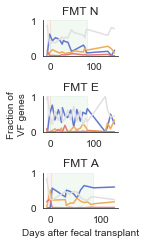

In [26]:
# plot FMT N, E, and A

fig = plt.figure(figsize = (2,3.5))

counter = 1
for patient, sub_df in vf_source_freq_filled.groupby('patient'):
    if patient in ['001', '007', '011']:
        ax = fig.add_subplot(3,1,counter)
        sns.lineplot(x='days_past_fmt', y='source_freq',
                     hue='source', data=sub_df, palette=dd_source_set)
        
        ax.axvspan(-8, 0, alpha=0.05, color='red') #antibiotics
        ax.axvspan(0, 84, alpha=0.05, color='green') #capsules
        
        ax.set_title(pub_label_dict[patient])
        
        ax.set_ylim(0, 1)
        
        if counter in [2]:
            ax.set_ylabel('Fraction of\nVF genes')
        else:
            ax.set_ylabel('')
        
        if counter in [3]:
            ax.set_xlabel('Days after fecal transplant')
        else:
            ax.set_xlabel('')
        
        ax.legend_.remove()
        
        counter += 1

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/vf_engfmt_ts_NEA_2019-05-07.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/vf_engfmt_ts_NEA_2019-05-07.pdf',
            dpi=300)

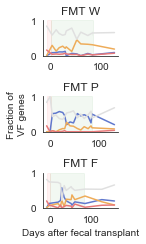

In [27]:
# plot FMT WPF

fig = plt.figure(figsize = (2,3.5))

counter = 1
for patient, sub_df in vf_source_freq_filled.groupby('patient'):
    if patient in ['008', '010', '014']:
        ax = fig.add_subplot(3,1,counter)
        sns.lineplot(x='days_past_fmt', y='source_freq',
                     hue='source', data=sub_df, palette=dd_source_set)
        
        ax.axvspan(-8, 0, alpha=0.05, color='red') #antibiotics
        ax.axvspan(0, 84, alpha=0.05, color='green') #capsules
        
        ax.set_title(pub_label_dict[patient])
        
        ax.set_ylim(0, 1)
        
        if counter in [2]:
            ax.set_ylabel('Fraction of\nVF genes')
        else:
            ax.set_ylabel('')
        
        if counter in [3]:
            ax.set_xlabel('Days after fecal transplant')
        else:
            ax.set_xlabel('')
        
        ax.legend_.remove()
        
        counter += 1

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/vf_engfmt_ts_WPF_2019-05-07.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/vf_engfmt_ts_WPF_2019-05-07.pdf',
            dpi=300)

In [31]:
#do this for cumulative abundance
vf_source_cabun = vf_source_df.groupby(['patient', 'sample_id', 
                                         'days_past_fmt', 'source'])['Count'].sum()

vf_source_cabun = vf_source_cabun.rename('cum_abun').reset_index()

#vf_source_cabun = vf_source_cabun.merge(vf_sample_sum)

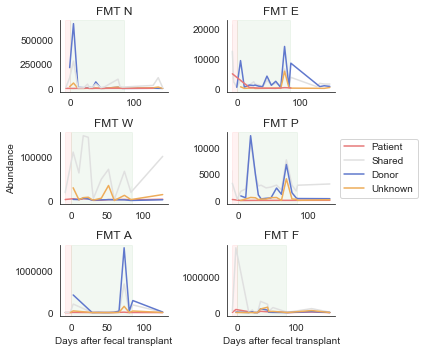

In [37]:
# plot these vf sources
#collapse all donor categories

fig = plt.figure(figsize = (6,5))

counter = 1
for patient, sub_df in vf_source_cabun.groupby('patient'):
    if patient in ['001', '007', '008', '010', '011', '014']:
        ax = fig.add_subplot(3,2,counter)
        sns.lineplot(x='days_past_fmt', y='cum_abun',
                     hue='source', data=sub_df, palette=dd_source_set)
        
        ax.axvspan(-8, 0, alpha=0.05, color='red') #antibiotics
        ax.axvspan(0, 84, alpha=0.05, color='green') #capsules
        
        ax.set_title(pub_label_dict[patient])
        
        #ax.set_ylim(0, 1)
        
        if counter in [3]:
            ax.set_ylabel('Abundance')
        else:
            ax.set_ylabel('')
        
        if counter in [5, 6]:
            ax.set_xlabel('Days after fecal transplant')
        else:
            ax.set_xlabel('')
        
        if counter != 4:
            ax.legend_.remove()
        else:
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),
                     labels=['Patient', 'Shared',
                             'Donor', 'Unknown']
                     )
        
        counter += 1

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/vf_cabun_source_ts_2019-05-05.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/vf_cabun_source_ts_2019-05-05.pdf',
            dpi=300)